Accuratezza media nel rilevamento delle aree/stanze dell’edificio

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Carica il dataset delle stanze
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.fillna(0, inplace=True)  # Gestisci i valori mancanti
    return df


In [123]:
# Prepara i dati per il modello
def prepare_data(df):
    le = LabelEncoder()
    df['room'] = le.fit_transform(df['room'])  # Codifica le stanze con numeri interi
    X = df.drop(columns=['room'])  # Caratteristiche (RSSI degli AP)
    y = df['room']  # Target (stanze)
    return X, y, le


In [124]:
from sklearn.ensemble import RandomForestClassifier

def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model


In [125]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_predictions(y_test, y_pred, le):
    # Calcola l'accuratezza
    accuracy = accuracy_score(y_test, y_pred)
    
    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return accuracy


In [126]:
'''def analyze_difficult_rooms(y_test, y_pred, le):
    errors = [(true, pred) for true, pred in zip(y_test, y_pred) if true != pred]
    difficult_rooms = pd.DataFrame(errors, columns=['True Room', 'Predicted Room'])
    difficult_counts = difficult_rooms.value_counts()
    print("\nStanze difficili da prevedere:")
    print(difficult_counts)'''
def analyze_difficult_rooms(y_test, y_pred, le):
    # Inverte le etichette numeriche per ottenere i nomi delle stanze
    true_rooms = le.inverse_transform(y_test)
    predicted_rooms = le.inverse_transform(y_pred)
    
    # Rimuovi \n o altri caratteri indesiderati dai nomi delle stanze
    true_rooms = [room.replace("\n", "").strip() for room in true_rooms]
    predicted_rooms = [room.replace("\n", "").strip() for room in predicted_rooms]
    
    # Crea un DataFrame con i risultati
    errors = [(true, pred) for true, pred in zip(true_rooms, predicted_rooms) if true != pred]
    difficult_rooms = pd.DataFrame(errors, columns=['True Room', 'Predicted Room'])
    
    # Conta le stanze difficili da prevedere
    difficult_counts = difficult_rooms.value_counts()
    
    print("\nStanze difficili da prevedere:")
    print(difficult_counts)



In [127]:
from sklearn.metrics import mean_absolute_error

def calculate_position_error(true_positions, predicted_positions):
    errors = [mean_absolute_error(true, pred) for true, pred in zip(true_positions, predicted_positions)]
    avg_error = sum(errors) / len(errors)
    print(f"Errore medio sulla posizione stimata: {avg_error:.2f}")


In [128]:
# Prepara i dati (X, y_encoded, le)
X, y_encoded, le = prepare_data(df)

# Dividi i dati in Training, Validation, e Test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [129]:
# Crea e allena il modello
model = train_model(X_train, y_train)

# Valuta il modello sui dati di validazione
val_accuracy = model.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Valuta il modello sui dati di test
test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predici le stanze sui dati di test
y_pred = model.predict(X_test)

# Valuta le predizioni e mostra la matrice di confusione
#accuracy = evaluate_predictions(y_test, y_pred, le)
#print(f"Accuratezza media nel rilevamento delle stanze: {accuracy:.2f}")


Validation Accuracy: 0.85
Test Accuracy: 0.88


In [130]:
import logging

logging.basicConfig(level=logging.INFO)

def log_model_training(model):
    try:
        logging.info("Modello addestrato con successo.")
    except Exception as e:
        logging.error(f"Errore durante l'addestramento del modello: {e}")

def log_predictions(y_test, y_pred):
    try:
        accuracy = accuracy_score(y_test, y_pred)
        logging.info(f"Accuratezza della predizione: {accuracy:.2f}")
    except Exception as e:
        logging.error(f"Errore durante la valutazione delle predizioni: {e}")


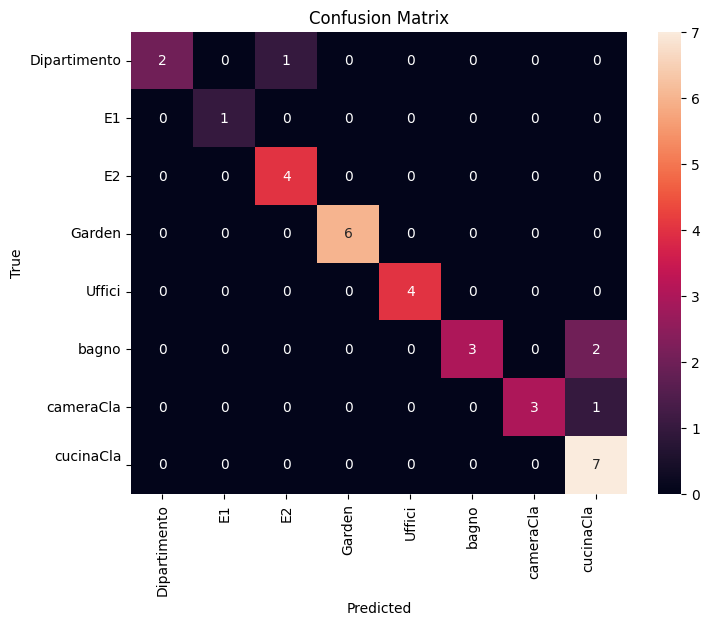


Classification Report:
              precision    recall  f1-score   support

Dipartimento       1.00      0.67      0.80         3
          E1       1.00      1.00      1.00         1
          E2       0.80      1.00      0.89         4
      Garden       1.00      1.00      1.00         6
      Uffici       1.00      1.00      1.00         4
       bagno       1.00      0.60      0.75         5
   cameraCla       1.00      0.75      0.86         4
  cucinaCla
       0.70      1.00      0.82         7

    accuracy                           0.88        34
   macro avg       0.94      0.88      0.89        34
weighted avg       0.91      0.88      0.88        34

Accuratezza media nel rilevamento delle stanze: 0.88

Stanze difficili da prevedere:
True Room     Predicted Room
bagno         cucinaCla         2
Dipartimento  E2                1
cameraCla     cucinaCla         1
Name: count, dtype: int64


In [131]:
file_path = r"..\backend\wifi_data_with_rooms.csv"  # Sostituisci con il percorso corretto del file
df = load_data(file_path)
X, y_encoded, le = prepare_data(df)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = train_model(X_train, y_train)

# Valuta sui set di validazione e test
val_accuracy = model.score(X_val, y_val)
test_accuracy = model.score(X_test, y_test)

y_pred = model.predict(X_test)

accuracy = evaluate_predictions(y_test, y_pred, le)
print(f"Accuratezza media nel rilevamento delle stanze: {accuracy:.2f}")

# Analisi delle stanze difficili
analyze_difficult_rooms(y_test, y_pred, le)
